In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vegetable-image-dataset


In [84]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from tqdm import trange
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

In [3]:
os.listdir("/kaggle/input/vegetable-image-dataset")

['Vegetable Images']

In [4]:
os.listdir("/kaggle/input/vegetable-image-dataset/Vegetable Images")

['validation', 'test', 'train']

In [6]:
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

In [8]:
train_dir = "/kaggle/input/vegetable-image-dataset/Vegetable Images/train"
test_dir = "/kaggle/input/vegetable-image-dataset/Vegetable Images/test"
val_dir = "/kaggle/input/vegetable-image-dataset/Vegetable Images/validation"

In [9]:
train_dataset = ImageFolder(train_dir, transform = transform)
test_dataset = ImageFolder(test_dir, transform = transform)
valid_dataset = ImageFolder(val_dir, transform = transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)

In [15]:
print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")
print(f"Size of validation dataset: {len(valid_dataset)}")

Size of training dataset: 15000
Size of test dataset: 3000
Size of validation dataset: 3000


In [21]:
print(f"Classes are: {train_dataset.classes}")
print(f"Number of classes: {len(train_dataset.classes)}")

Classes are: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Number of classes: 15


In [22]:
num_classes = len(train_dataset.classes)
num_classes

15

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [54]:
def plot_results(train_losses, valid_losses, train_accs, valid_accs):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_accs) + 1, 1)
    axes[0].plot(xs, train_losses, label = "Training Loss")
    axes[0].plot(xs, valid_losses, label = "Validation Loss")
    axes[0].set_title("Training loss vs Validation loss", fontsize = 15)
    axes[0].set_xlabel("Epoch", fontsize = 10)
    axes[0].set_ylabel("Loss", fontsize = 10)
    axes[0].set_xticks(xs)
    axes[0].legend()
    axes[1].plot(xs, train_accs, label = "Training Accuracy")
    axes[1].plot(xs, valid_accs, label = "Validation Accuracy")
    axes[1].set_title("Training accuracy vs Validation accuracy", fontsize = 15)
    axes[1].set_xlabel("Epoch", fontsize = 10)
    axes[1].set_ylabel("Accuracy", fontsize = 10)
    axes[1].set_xticks(xs)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [25]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    model.train()
    total_loss = 0
    total_acc = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [29]:
def valid_step(model, criterion, dataloader, device = device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += criterion(preds, y).item()
            total_acc += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [51]:
def train_model(model, n_epochs, optimizer, train_loader, valid_loader, device = device):
    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []
    criterion = nn.CrossEntropyLoss()
    pbar = trange(n_epochs)
    for epoch in pbar:
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = valid_step(model, criterion, valid_loader, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        pbar.set_description(f"Training Acc: {train_acc:.3f} | Valid Acc: {valid_acc:.3f} | Training Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}")
    plot_results(train_losses, valid_losses, train_accs, valid_accs)
    return {'train_loss': train_loss, 'train_acc': train_acc, 'valid_loss': valid_loss, 'valid_acc': valid_acc}

In [55]:
class NN1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN1, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Training Acc: 97.167 | Valid Acc: 85.833 | Training Loss: 0.099 | Valid Loss: 0.666: 100%|██████████| 10/10 [06:08<00:00, 36.82s/it]


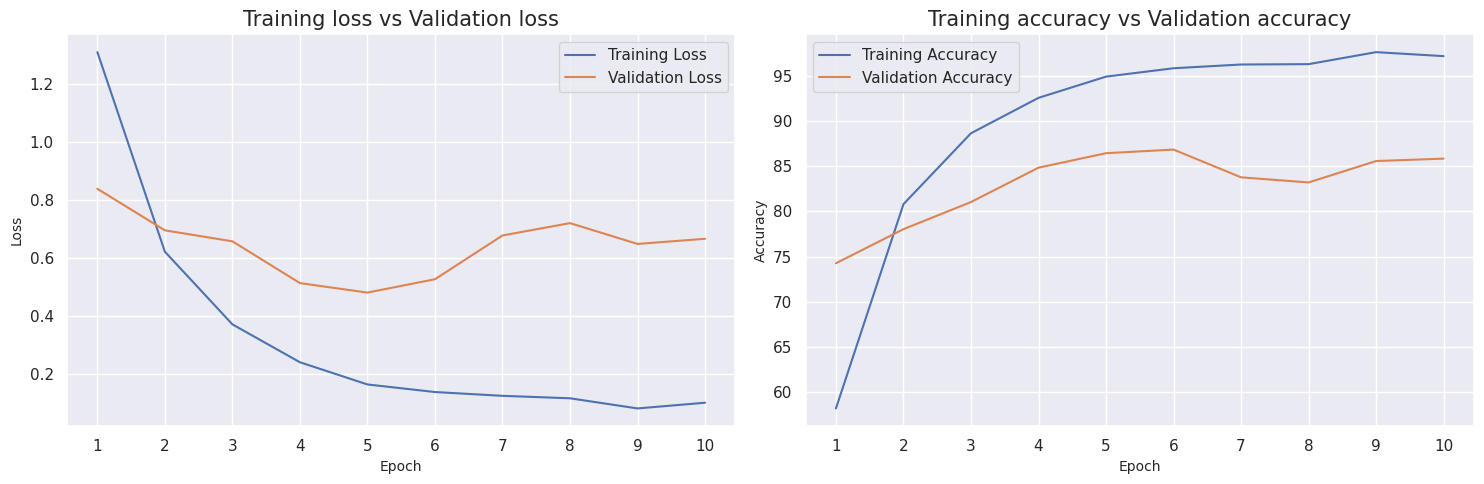

In [56]:
model1 = NN1(input_size = 80 * 80 * 3, num_classes = num_classes).to(device) 
optimizer = optim.Adam(model1.parameters(), lr = 0.001)
results = train_model(model1, 10, optimizer, train_loader, valid_loader, device = device)

In [60]:
class NN2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN2, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Training Acc: 87.673 | Valid Acc: 85.767 | Training Loss: 0.393 | Valid Loss: 0.508: 100%|██████████| 10/10 [06:06<00:00, 36.62s/it]


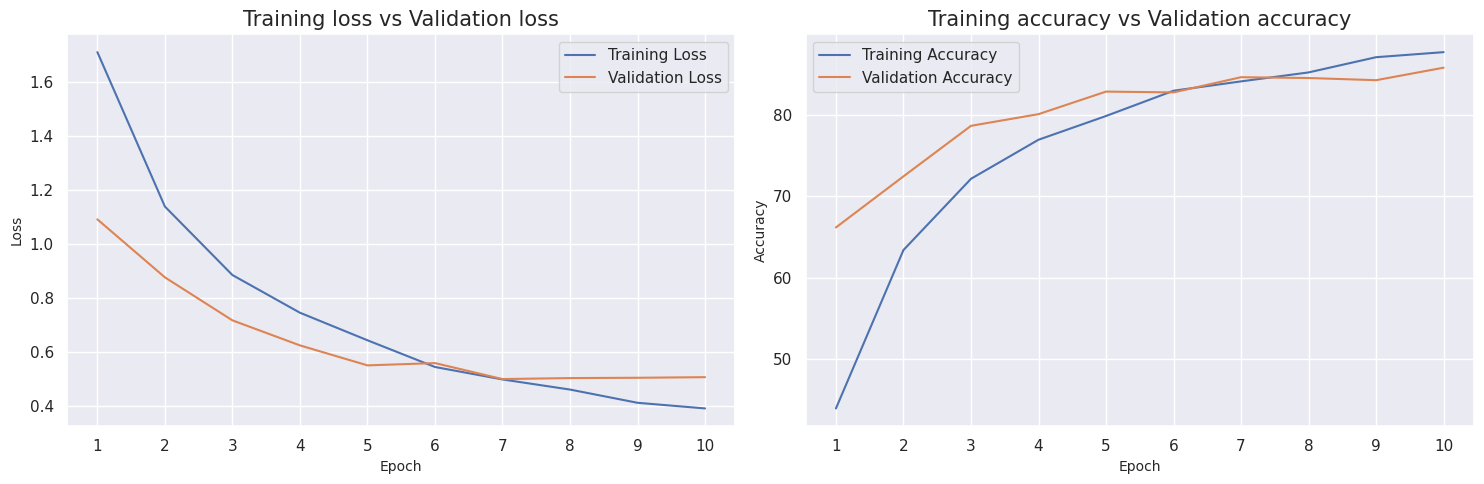

In [61]:
model2 = NN2(input_size = 80 * 80 * 3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
results = train_model(model2, 10, optimizer, train_loader, valid_loader, device = device)

In [62]:
class NN3(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN3, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Training Acc: 98.320 | Valid Acc: 90.267 | Training Loss: 0.063 | Valid Loss: 0.336: 100%|██████████| 10/10 [06:01<00:00, 36.20s/it]


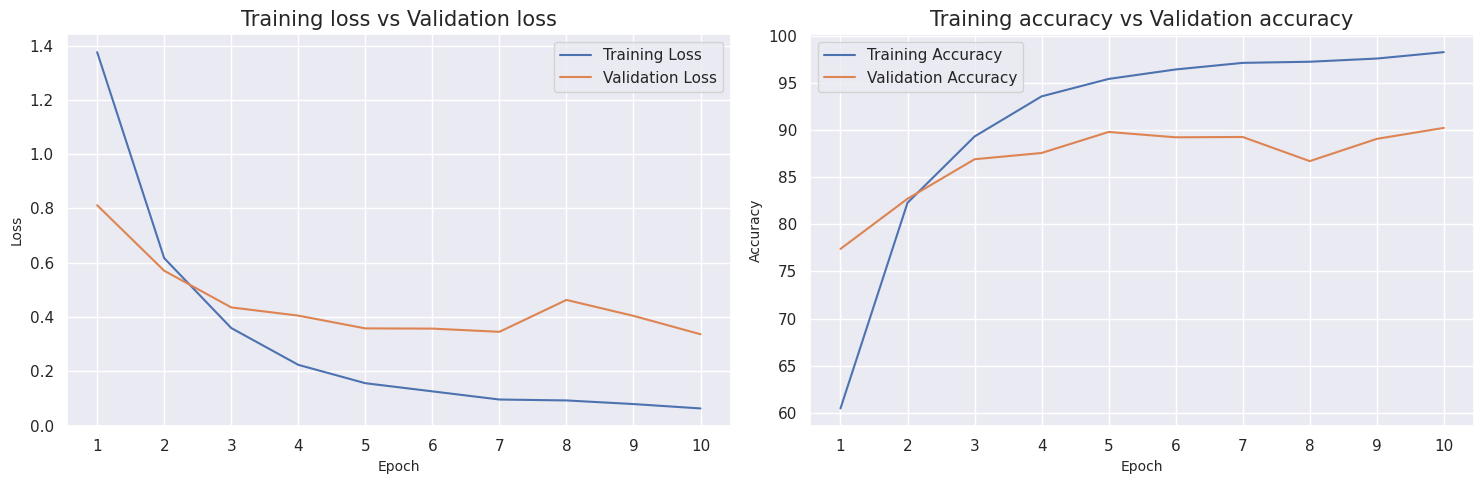

In [63]:
model3 = NN3(input_size = 80 * 80 * 3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model3.parameters(), lr = 0.001)
results = train_model(model3, 10, optimizer, train_loader, valid_loader, device = device)

In [64]:
class NN4(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN4, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Training Acc: 89.293 | Valid Acc: 89.200 | Training Loss: 0.329 | Valid Loss: 0.378: 100%|██████████| 10/10 [05:58<00:00, 35.82s/it]


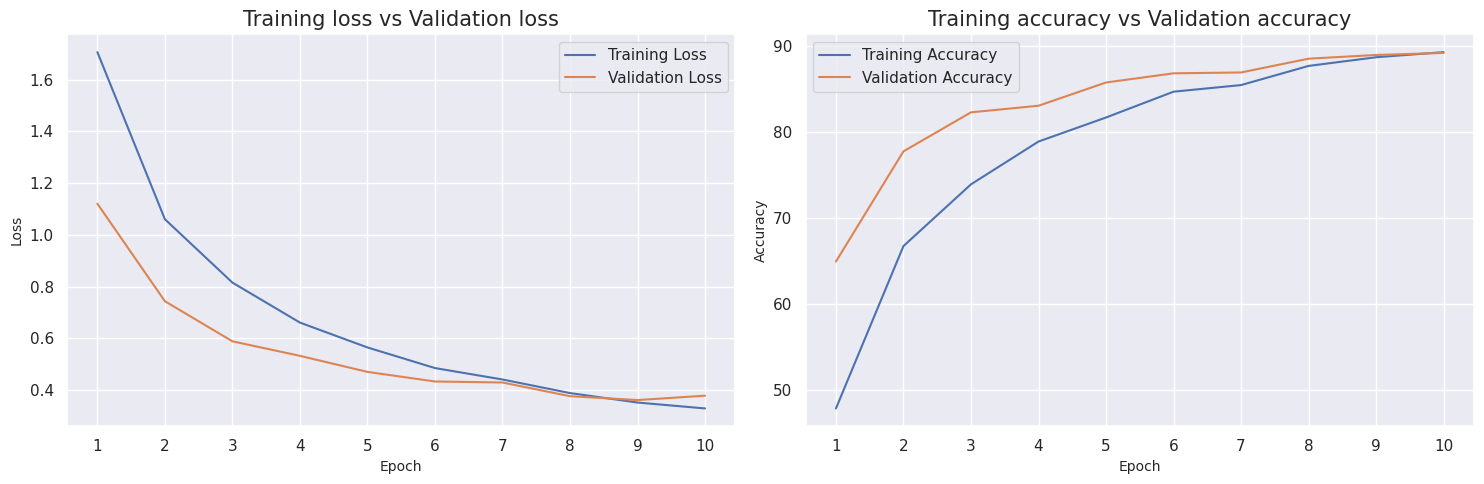

In [65]:
model4 = NN4(input_size = 80 * 80 * 3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model4.parameters(), lr = 0.001)
results = train_model(model4, 10, optimizer, train_loader, valid_loader, device = device)

In [83]:
model4.eval()
criterion = nn.CrossEntropyLoss()
test_loss = 0
test_acc = 0
test_labels = []
test_preds = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model4(x)

        test_loss += criterion(preds, y).item()
        test_acc += (preds.argmax(dim=1) == y).sum().item()

        test_preds.extend(preds.argmax(dim=1).cpu().numpy())
        test_labels.extend(y.cpu().numpy())

f_loss = test_loss / len(test_loader)
f_acc = 100 * test_acc / len(test_loader.dataset)

print(f"Test Loss: {f_loss:.3f} | Test Acc: {f_acc:.3f}")

Test Loss: 0.355 | Test Acc: 89.033


In [85]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       200
           1       0.86      0.93      0.89       200
           2       0.95      0.94      0.95       200
           3       0.84      0.86      0.85       200
           4       0.90      0.88      0.89       200
           5       0.77      0.85      0.81       200
           6       0.96      0.97      0.96       200
           7       0.93      0.97      0.95       200
           8       0.85      0.84      0.84       200
           9       0.90      0.90      0.90       200
          10       0.98      0.90      0.94       200
          11       0.93      0.93      0.93       200
          12       0.82      0.87      0.84       200
          13       0.95      0.91      0.93       200
          14       0.84      0.82      0.83       200

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89   

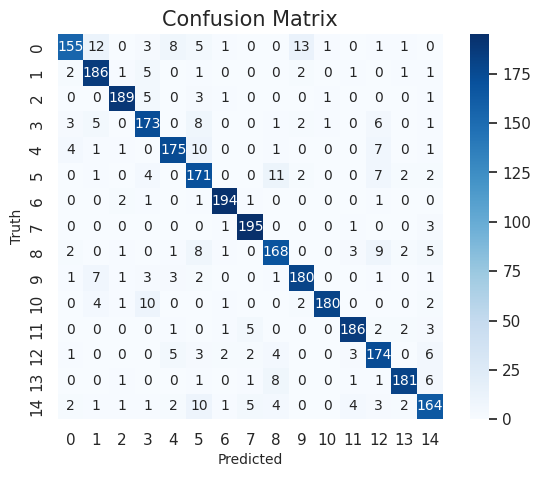

In [86]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(test_labels, test_preds), annot = True, cbar = True, square = True, annot_kws = {'size': 10}, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()

In [104]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, ReLU, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [132]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (80, 80),
    batch_size = 64
)

Found 15000 files belonging to 15 classes.


In [133]:
valid_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size = (80, 80),
    batch_size = 64
)

Found 3000 files belonging to 15 classes.


In [134]:
def normalize_img(image, label):
    image = (tf.cast(image, tf.float32) / 255.0 - 0.5) / 0.5
    return image, label

In [135]:
train_ds = train_data.map(normalize_img)

In [136]:
valid_ds = valid_data.map(normalize_img)

In [145]:
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = (80, 80),
    batch_size = 64,
    shuffle = False
)

Found 3000 files belonging to 15 classes.


In [146]:
test_ds = test_data.map(normalize_img)

In [139]:
tf_model = Sequential([
    Flatten(input_shape = (80, 80, 3)),
    
    Dense(256, kernel_initializer = tf.keras.initializers.HeUniform()),
    BatchNormalization(momentum = 0.1, epsilon = 1e-5),
    ReLU(),
    Dropout(0.25),
    
    Dense(128, kernel_initializer = tf.keras.initializers.HeUniform()),
    BatchNormalization(momentum = 0.1, epsilon = 1e-5),
    ReLU(),
    Dropout(0.25),
    
    Dense(64, kernel_initializer = tf.keras.initializers.HeUniform()),
    BatchNormalization(momentum = 0.1, epsilon = 1e-5),
    ReLU(),
    Dropout(0.10),
    
    Dense(num_classes)
])

In [140]:
tf_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [141]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [142]:
history = tf_model.fit(train_ds, validation_data = valid_ds, epochs = 30, callbacks = [early_stopping])

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.3459 - loss: 2.0821 - val_accuracy: 0.6497 - val_loss: 1.1320
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6200 - loss: 1.2153 - val_accuracy: 0.7403 - val_loss: 0.8465
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7021 - loss: 0.9255 - val_accuracy: 0.7540 - val_loss: 0.7857
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7548 - loss: 0.7560 - val_accuracy: 0.7843 - val_loss: 0.7004
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7890 - loss: 0.6564 - val_accuracy: 0.8143 - val_loss: 0.6197
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8280 - loss: 0.5352 - val_accuracy: 0.8140 - val_loss: 0.6079
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8531 - loss: 0.4773 - val_accuracy: 0.7923 - val_loss: 0.7251
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8653 - loss: 0.4249 - val_acc

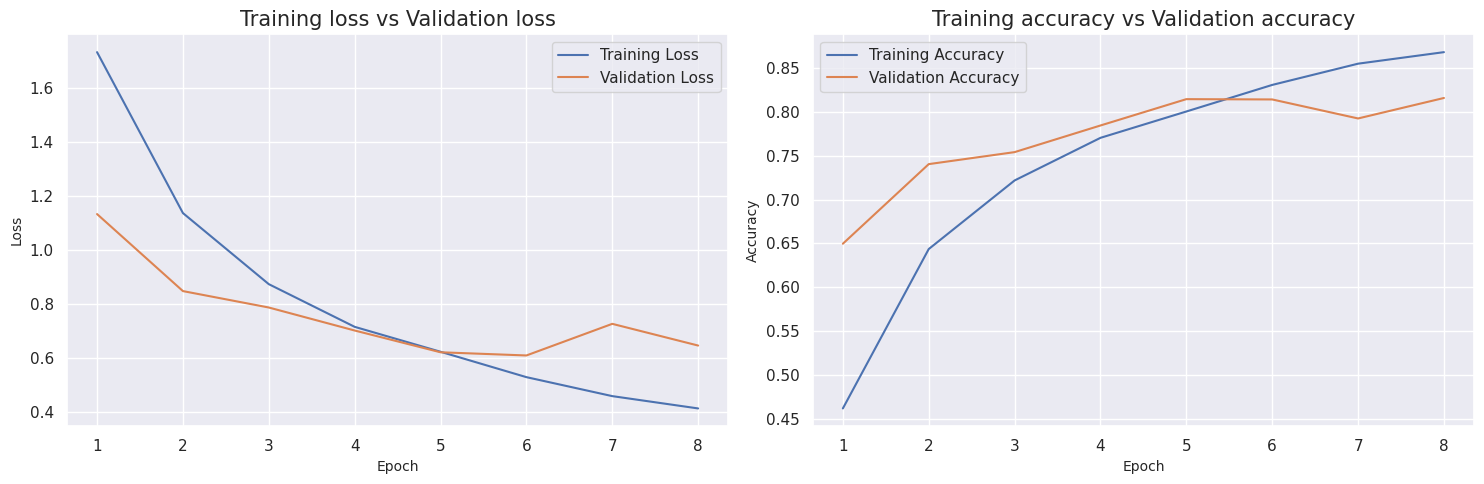

In [143]:
plot_results(history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy'])

In [147]:
tf_model.evaluate(test_ds)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7431 - loss: 0.8066


[0.6111479997634888, 0.8063333630561829]

In [148]:
predictions = tf_model.predict(test_ds)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


In [149]:
pr_labels = np.argmax(predictions, axis = 1)

In [150]:
true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis = 0)

In [151]:
print(classification_report(true_labels, pr_labels))

              precision    recall  f1-score   support

           0       0.88      0.53      0.66       200
           1       0.90      0.75      0.82       200
           2       0.90      0.88      0.89       200
           3       0.87      0.73      0.80       200
           4       0.84      0.70      0.77       200
           5       0.54      0.86      0.66       200
           6       0.92      0.92      0.92       200
           7       0.96      0.94      0.95       200
           8       0.80      0.70      0.74       200
           9       0.85      0.82      0.84       200
          10       0.79      0.95      0.86       200
          11       0.93      0.88      0.90       200
          12       0.87      0.65      0.74       200
          13       0.73      0.95      0.82       200
          14       0.65      0.84      0.73       200

    accuracy                           0.81      3000
   macro avg       0.83      0.81      0.81      3000
weighted avg       0.83   

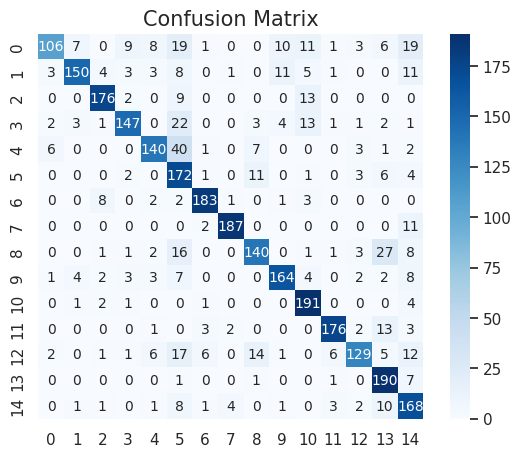

In [152]:
plt.figure(figsize = (7, 5))
plt.title("Confusion Matrix", fontsize = 15)
plt.xlabel("Predicted", fontsize = 10)
plt.ylabel("Truth", fontsize = 10)
sns.heatmap(confusion_matrix(true_labels, pr_labels), annot = True, square = True, cbar = True, fmt = 'd', annot_kws = {'size': 10}, cmap = 'Blues')
plt.show()